# 梯度下降和随机梯度下降——使用Gluon

在`Gluon`里，使用小批量随机梯度下降很方便，我们无需重新实现该算法。特别地，当批量大小等于数据集样本数时，该算法即为梯度下降；批量大小为1即为随机梯度下降。

首先，导入本节中实验所需的包。

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import sys
import mxnet as mx
from mxnet import autograd, gluon, nd
import numpy as np
sys.path.append('..')
import utils

下面生成实验数据集并定义线性回归模型。

In [2]:
# 生成数据集。
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
X = nd.random.normal(scale=1, shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += 0.01 * nd.random.normal(scale=1, shape=y.shape)

# 线性回归模型。
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(1))

为了使学习率能够自我衰减，我们需要访问`gluon.Trainer`的`learning_rate`属性并使用`set_learning_rate`函数。

In [3]:
# 优化目标函数。
def optimize(batch_size, trainer, num_epochs, decay_epoch, log_interval, X, y,
             net):
    dataset = gluon.data.ArrayDataset(X, y)
    data_iter = gluon.data.DataLoader(dataset, batch_size, shuffle=True)
    square_loss = gluon.loss.L2Loss()
    y_vals = [square_loss(net(X), y).mean().asnumpy()]
    for epoch in range(1, num_epochs + 1): 
        # 学习率自我衰减。
        if decay_epoch and epoch > decay_epoch:
            trainer.set_learning_rate(trainer.learning_rate * 0.1)
        for batch_i, (features, label) in enumerate(data_iter):
            with autograd.record():
                output = net(features)
                loss = square_loss(output, label)
            loss.backward()
            trainer.step(batch_size)
            if batch_i * batch_size % log_interval == 0:
                y_vals.append(square_loss(net(X), y).mean().asnumpy())
    # 为了便于打印，改变输出形状并转化成numpy数组。
    print('w:', net[0].weight.data(), '\nb:', net[0].bias.data(), '\n')
    x_vals = np.linspace(0, num_epochs, len(y_vals), endpoint=True)
    utils.semilogy(x_vals, y_vals, 'epoch', 'loss')

以下几组实验分别重现了["梯度下降和随机梯度下降——从零开始"](gd-sgd-scratch.md)一节中实验结果。

w: 
[[ 1.99880958 -3.40056562]]
<NDArray 1x2 @cpu(0)> 
b: 
[ 4.20068264]
<NDArray 1 @cpu(0)> 



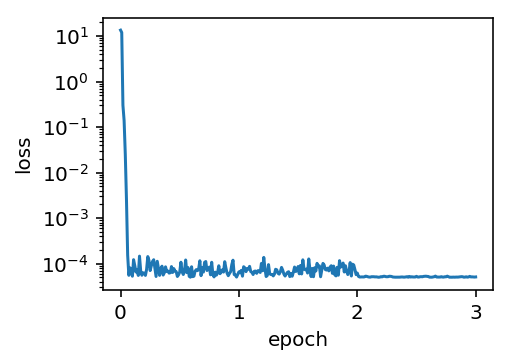

In [4]:
net.collect_params().initialize(mx.init.Normal(sigma=1), force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.2})
optimize(batch_size=1, trainer=trainer, num_epochs=3, decay_epoch=2,
         log_interval=10, X=X, y=y, net=net)

w: 
[[ 2.00041699 -3.40231657]]
<NDArray 1x2 @cpu(0)> 
b: 
[ 4.19891977]
<NDArray 1 @cpu(0)> 



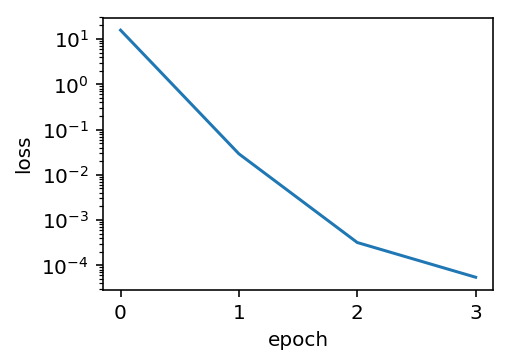

In [5]:
net.collect_params().initialize(mx.init.Normal(sigma=1), force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.999})
optimize(batch_size=1000, trainer=trainer, num_epochs=3, decay_epoch=None,
         log_interval=1000, X=X, y=y, net=net)

w: 
[[ 1.99993885 -3.40029502]]
<NDArray 1x2 @cpu(0)> 
b: 
[ 4.20026875]
<NDArray 1 @cpu(0)> 



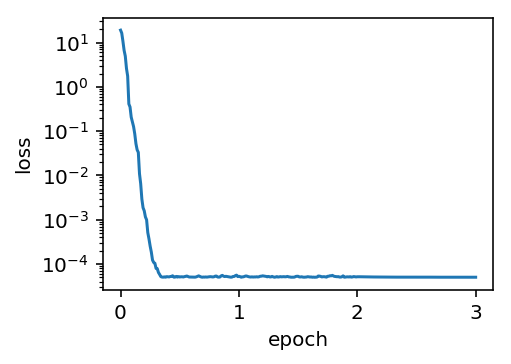

In [6]:
net.collect_params().initialize(mx.init.Normal(sigma=1), force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.2})
optimize(batch_size=10, trainer=trainer, num_epochs=3, decay_epoch=2,
         log_interval=10, X=X, y=y, net=net)

w: 
[[ nan  nan]]
<NDArray 1x2 @cpu(0)> 
b: 
[ nan]
<NDArray 1 @cpu(0)> 



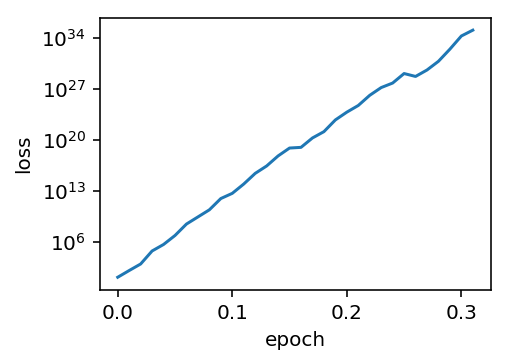

In [7]:
net.collect_params().initialize(mx.init.Normal(sigma=1), force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 5})
optimize(batch_size=10, trainer=trainer, num_epochs=3, decay_epoch=2,
         log_interval=10, X=X, y=y, net=net)

w: 
[[ 0.58623546 -1.52983904]]
<NDArray 1x2 @cpu(0)> 
b: 
[ 1.38468301]
<NDArray 1 @cpu(0)> 



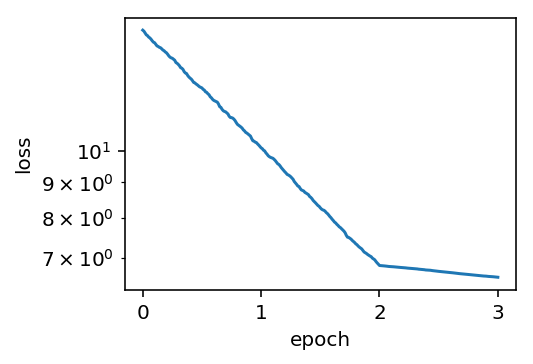

In [8]:
net.collect_params().initialize(mx.init.Normal(sigma=1), force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.002})
optimize(batch_size=10, trainer=trainer, num_epochs=3, decay_epoch=2,
         log_interval=10, X=X, y=y, net=net)

## 小结

* 使用Gluon的`Trainer`可以方便地使用小批量随机梯度下降。
* 访问`gluon.Trainer`的`learning_rate`属性并使用`set_learning_rate`函数可以在迭代过程中调整学习率。


## 练习

* 查阅网络或书本资料，了解学习率自我衰减的其他方法。


## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/1878)


![](../img/qr_gd-sgd-gluon.svg)